In [21]:
from reliability.Distributions import Weibull_Distribution
from reliability.Fitters import Fit_Weibull_2P
from reliability.Probability_plotting import plot_points
import matplotlib.pyplot as plt
import pandas as pd
import string

Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 20/0 (0% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         28.1696         3.57032   21.9733   36.1131
     Beta         1.86308         0.32449   1.32428   2.62111 

Goodness of fit    Value
 Log-likelihood -79.5482
           AICc  163.802
            BIC  165.088
             AD  0.83728 



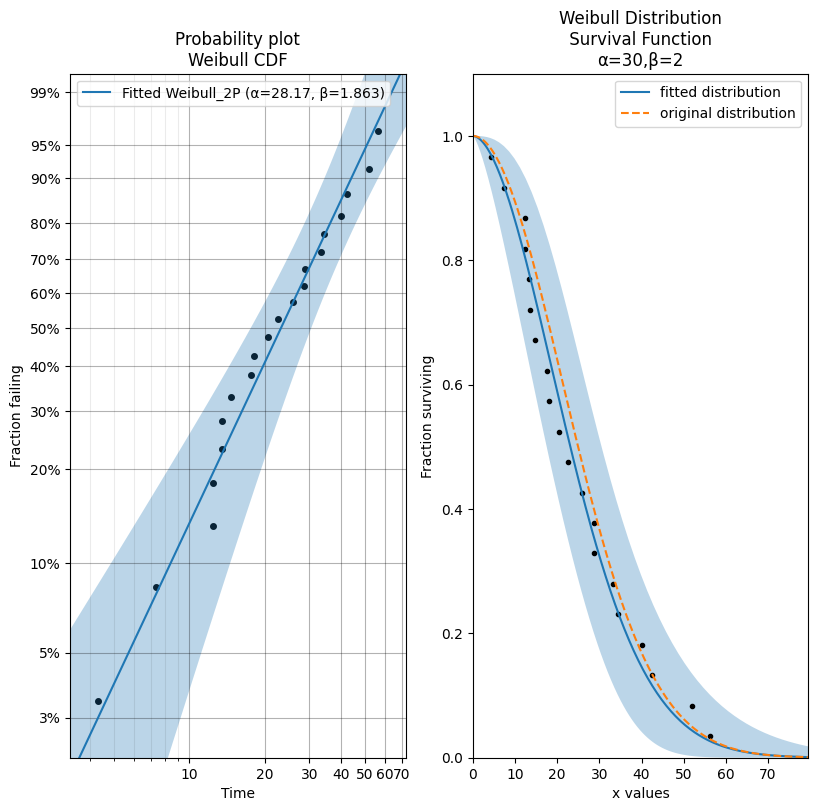

In [22]:
dist = Weibull_Distribution(alpha=30, beta=2)  # creates the distribution object
data = dist.random_samples(20, seed=42)  # draws 20 samples from the distribution. Seeded for repeatability
plt.subplot(121)
fit = Fit_Weibull_2P(failures=data)  # fits a Weibull distribution to the data and generates the probability plot
plt.subplot(122)
fit.distribution.SF(label='fitted distribution')  # uses the distribution object from Fit_Weibull_2P and plots the survival function
dist.SF(label='original distribution', linestyle='--') # plots the survival function of the original distribution
plot_points(failures=data, func='SF')  # overlays the original data on the survival function
plt.legend()
plt.show()

In [23]:
data

array([20.55094355, 52.04910458, 34.42486201, 28.66440822, 12.355662  ,
       12.35462111,  7.33858922, 42.54536142, 28.76063174, 33.28851237,
        4.32658956, 56.15337681, 40.09721423, 14.65670027, 13.43916254,
       13.50371358, 18.06871209, 25.87537532, 22.56065957, 17.60115602])

In [24]:
test_data = pd.read_csv("Test_data.csv")

test_data

,Unnamed: 0,Proben-Nr.,Datum/Uhrzeit,Fcr,...,Moment,failure stress,Unnamed: 10,Diameter.1
0,NaN,NaN,NaN,N,...,Nmm,N/mm^2,NaN,mm
1,Probe 1,1,45420.6,22.85162354,...,342.8,76.7,NaN,3.57
2,Probe 2,2,45420.7,22.49817848,...,337.5,74.9,NaN,3.58
3,Probe 3,3,45420.7,18.44078827,...,276.6,62.4,NaN,3.56
4,Probe 4,4,45420.7,22.20804024,...,333.1,79.8,NaN,3.49
5,Probe 5,5,45420.7,23.90054512,...,358.5,83.7,NaN,3.52
6,Probe 6,6,45420.7,25.65187645,...,384.8,87.6,NaN,3.55
7,Probe 7,7,45420.7,26.03781509,...,390.6,87.4,NaN,3.57
8,Probe 8,8,45420.7,26.57203484,...,398.6,93.1,NaN,3.52
9,Probe 9,9,45420.7,18.93573761,...,284.0,65.8,NaN,3.53


In [25]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(test_data):
    # Drop columns: 'Unnamed: 0', 'Unnamed: 10'
    test_data = test_data.drop(columns=['Unnamed: 0', 'Unnamed: 10'])
    # Drop rows with missing data in column: 'Proben-Nr.'
    test_data = test_data.dropna(subset=['Proben-Nr.'])
    # Change column type to uint32 for column: 'Proben-Nr.'
    test_data = test_data.astype({'Proben-Nr.': 'uint32'})
    # Rename column 'Proben-Nr.' to 'Probe_Num'
    test_data = test_data.rename(columns={'Proben-Nr.': 'Probe_Num'})
    return test_data

test_data_clean = clean_data(test_data.copy())
test_data_clean.head()

,Probe_Num,Datum/Uhrzeit,Fcr,Diameter,...,span,Moment,failure stress,Diameter.1
1,1,45420.6,22.85162354,3.57,...,30.0,342.8,76.7,3.57
2,2,45420.7,22.49817848,3.58,...,30.0,337.5,74.9,3.58
3,3,45420.7,18.44078827,3.56,...,30.0,276.6,62.4,3.56
4,4,45420.7,22.20804024,3.49,...,30.0,333.1,79.8,3.49
5,5,45420.7,23.90054512,3.52,...,30.0,358.5,83.7,3.52


In [26]:
fail_data = test_data_clean['failure stress'].to_numpy(dtype="float32")
type(fail_data[5])

numpy.float32

Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 32/0 (0% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         88.9102         2.37043   84.3835   93.6797
     Beta         7.03417        0.893657   5.48368   9.02306 

Goodness of fit    Value
 Log-likelihood -127.101
           AICc  258.616
            BIC  261.133
             AD 0.963038 



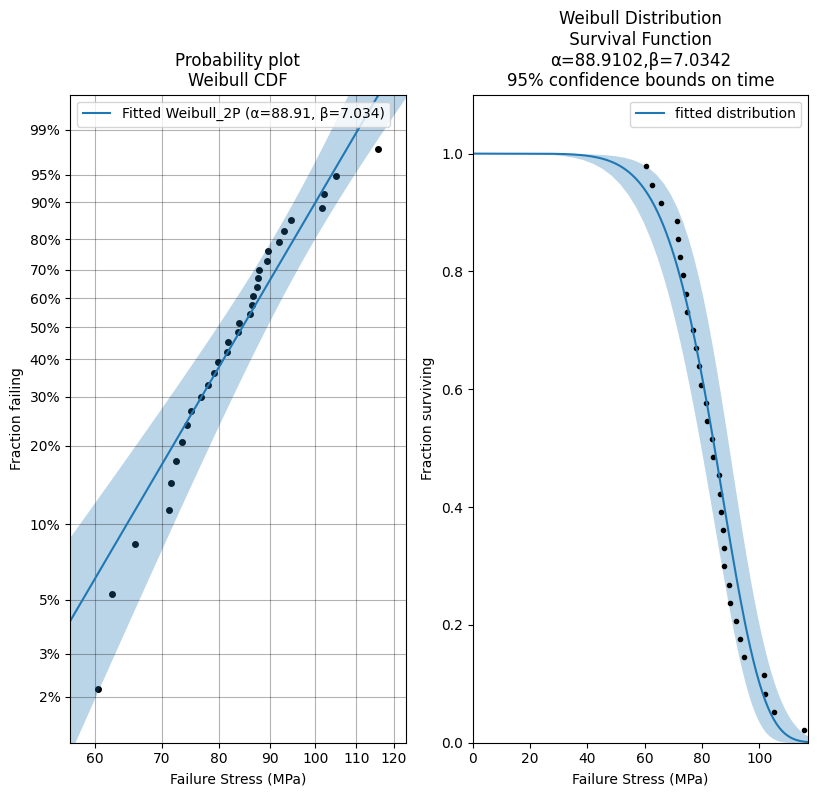

In [27]:
plt.clf()
plt.subplot(121)
test_fit = Fit_Weibull_2P(failures=fail_data)  # fits a Weibull distribution to the data and generates the probability plot
plt.xlabel("Failure Stress (MPa)")
plt.subplot(122)
test_fit.distribution.SF(label='fitted distribution')  # uses the distribution object from Fit_Weibull_2P and plots the survival function
plot_points(failures=fail_data, func='SF')  # overlays the original data on the survival function
plt.legend()
plt.xlabel("Failure Stress (MPa)")
plt.show()

# Generate Weibull

In [28]:
gcc_data = pd.read_csv("Maple Rod Testing Analysis.csv")

gcc_data

,Number,Fracture load,Fracture Stress
0,B1,46.7887,67.761
1,B2,85.8979,170.977
2,B3,54.1228,102.886
3,B4,64.6418,122.189
4,B5,78.9588,174.763
5,B6,57.2761,116.623
6,B7,68.1001,128.726
7,B8,80.9788,162.4
8,B9,56.073,108.539
9,B10,92.3955,179.794


In [29]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(gcc_data):
    # Drop rows with missing data in column: 'Fracture Stress'
    gcc_data = gcc_data.dropna(subset=['Fracture Stress'])
    return gcc_data

gcc_data_clean = clean_data(gcc_data.copy())
gcc_data_clean.head()

,Number,Fracture load,Fracture Stress
0,B1,46.7887,67.761
1,B2,85.8979,170.977
2,B3,54.1228,102.886
3,B4,64.6418,122.189
4,B5,78.9588,174.763


In [30]:
gcc_data_clean[gcc_data_clean["Number"].str.startswith("B")]

,Number,Fracture load,Fracture Stress
0,B1,46.7887,67.761
1,B2,85.8979,170.977
2,B3,54.1228,102.886
3,B4,64.6418,122.189
4,B5,78.9588,174.763
5,B6,57.2761,116.623
6,B7,68.1001,128.726
7,B8,80.9788,162.4
8,B9,56.073,108.539
9,B10,92.3955,179.794


In [35]:
gcc_data_clean["Series"] = gcc_data_clean["Number"].str[0]

gcc_data_clean

,Number,Fracture load,Fracture Stress,Series
0,B1,46.7887,67.761,B
1,B2,85.8979,170.977,B
2,B3,54.1228,102.886,B
3,B4,64.6418,122.189,B
4,B5,78.9588,174.763,B
5,B6,57.2761,116.623,B
6,B7,68.1001,128.726,B
7,B8,80.9788,162.4,B
8,B9,56.073,108.539,B
9,B10,92.3955,179.794,B
